# Résolution de l'équation de la chaleur par différences finies

## Résolution pour une solution $u$ triviale

Dans cette partie, on s'intéresse à la résolution de l'équation de la chaleur, c'est à dire à la discrétisation du problème suivant : 

$$
\left\{
    \begin{array}{ll}
        \dfrac{\partial u}{\partial t} = \Delta u &{sur }\quad \Omega = [0,1]\times[0,1]\\
        u = 0 &\mbox{sur } \quad \partial \Omega
    \end{array}
\right.
$$

Nous remarquons que nous utilisons des conditions de bord de type Dirichlet. Pour approximer la solution, nous allons utiliser une méthode de discrétisation par différences finies de type implicite. Nous obtenons le calcul suivant :

$$
\dfrac{U^{n+1} - U^n}{\delta t} = AU^{n+1}
$$

où $U$ représente le vecteur solution et $A$ la matrice de discrétisation du Laplacien. Le réel $\delta t$ représente le pas de temps. Le vecteur $u$ est dit trivial dans le titre de cette partie car nous l'initialiserons à un vecteur de 1 tout en prenant en compte les conditions de bord. Dans la partie suivante, nous appliquerons cette équation de diffusion à une fonction $u$ donnée.

Nous obtenons l'expression finale : 

$$
U^{n+1} = (I - \delta t A)^{-1}U^n
$$

La stratégie adoptée pour coder ce problème sera la suivante. Dans un premier temps, nous allons écrire la matrice de $(I -\delta t A)$ en s'inspirant de notre travail sur l'équation de Poisson. Dans un second temps, nous ajouterons la boucle temporelle et nous finirons par afficher le résultat final.

Pour commencer, nous allons importer les packages nécessaires.

In [1]:
import numpy as np                        #Package pour calculs scientifiques
import scipy.sparse as sparse             #Algèbre linéaire creuse
import matplotlib.pyplot as plt           #Permet la création de graphique  
import scipy.sparse.linalg as sci         #Contient plusieurs packages pour le calcul scientifique
from mpl_toolkits.mplot3d import Axes3D   #Utile pou le graphiques 3D
import time                               #Affichage du temps de calcul
from IPython.display import Image         #Affichage d'image dans le Jupyter

La fonction suivante retourne la matrice de $(I - \delta t A)$. Ce sera une matrice sparse de taille $(N+1)\times(N+1)$. Elle regroupera donc l'intégralité des points du maillage et nous permettra de résoudre le système linéaire en insérant les conditions de bords ($u = 0$) directement dans le second membre. La fonction suivante prendra en paramètre le nombre $N$ d'intervalles et la pas de temps $\delta t$.

In [2]:
def matrix_lap2(N,dt):
    """Retourne la matrice de (I -dtA) dans le domaine Omega = [0,1]x[0,1] 
    découpé en N intervalles en x et y. La matrice finale est une matrice scipy.sparse CSR matrix. 
    Cette matrice est de taille (N+1)*(N+1)"""

    h = 1./N
    h2 = h*h

    #On note les inconnues de 0 à Nx suivant x et 0 à Ny suivant y. 
    #La taille du problème est donc (Nx+1)*(Ny+1).
    #Ici le pas d'espace est le même entre x et y.
    #Cela correspond à x_i = i*h et y_j = j*h 
    #et la numérotation (i,j) --> k := (N+1)*j+i.

    taille = (1+N)*(1+N)

    diags = np.zeros((5,taille))                          #Création du tableau des diagonales

    #Diagonale principale
    diags[2,:] = 1.
    diags[2, N+2:taille - (N+2)] = 1 + ((4*dt)/h2)
    diags[2, np.arange(2*N+1, taille, N+1)] = 1.
    diags[2, np.arange(2*N+2, taille, N+1)] = 1.
              
    #Diagonale "-1"
    diags[1,N+1:taille-(N+1)] = -dt/h2
    diags[1, np.arange(2*N, taille, N+1)] = 0.
    diags[1, np.arange(2*N+1, taille, N+1)] = 0.
    
    #Diagonale "+1"
    diags[3, N+3:taille-(N+1)] = -dt/h2
    diags[3, np.arange(2*N+2, taille, N+1)] = 0.
    diags[3, np.arange(2*N+3, taille, N+1)] = 0.

    #Diagonale "-(N+1)"
    diags[0, 1 : taille - (2*N+3)] = -dt/h2
    diags[0, np.arange(N,taille,N+1)] = 0.
    diags[0, np.arange(N+1,taille,N+1)] = 0.

    #Diagonale "+(N+1)"
    diags[4, taille - N*N + 2 : taille - 1] = -dt/h2
    diags[4, np.arange(taille - N*N + 1 + N ,taille,N+1)] = 0.
    diags[4, np.arange(taille - N*N + 2 + N ,taille,N+1)] = 0.

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-(N+1),-1,0,1,(N+1)],taille,taille, format = "csc")

    return A


Regardons ce qu'affiche la matrice $A$ pour $N = 2$ et un pas de temps $\delta t = 0.1$

In [3]:
A = matrix_lap2(2,0.1)
print(A.todense())

[[ 1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   1.   0.   0.   0.   0.   0. ]
 [ 0.  -0.4  0.  -0.4  2.6 -0.4  0.  -0.4  0. ]
 [ 0.   0.   0.   0.   0.   1.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   1.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   1. ]]


Nous pouvons aussi, comme en début de rapport de voir un aperçu graphique de la matrice pour une valeur de $N = 7$

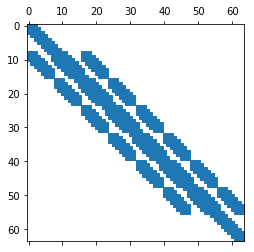

In [4]:
plt.spy(matrix_lap2(7,0.1))

On remarque que la matrice obtenue correspond, visuellement, à celle que l'on doit obtenir. Finalement, on rédige l'algorithme pour résoudre le système linéaire. Nous avons décidé de créer un tableau des temps en 2 dimensions, dans lequel on stockera la solution à chaque temps $t$. Cela permettra à l'utilisateur de choisir quel temps il voudra afficher dans un intervalle $[0,T]$. Dans le cadre de ce rapport, nous afficherons seulement pour $t = 0$ et $t = T$. Le fait de stocker la solution, à chaque temps, dans un tableau peut-être très coûteuse. Nous verrons par la suite qu'il est également possible de stocker chaque solution dans un fichier, ce qui rend l'opération moins lourde pour l'ordinateur. On obtient la fonction suivante.

In [5]:
def chaleur_triv(N,dt,t):

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    taille1 = (N+1)*(N+1)

    #Initialisation du tableau en 2 dimensions, (t+1) 
    #en première composante pour le nombre de d'intervalle de temps
    #et (taille1) en seconde composante pour stocker le tableau de solution
    
    T = np.zeros((t+1,taille1))     
    
    #Initialisation de la solution finale. 
    #On met des 0 sur les bords pour valider les conditions initiales 
    #et on initialise le reste à 1. 
    
    T[0,N+2:taille1 - N-2] = 1.
    T[0,np.arange(2*N+1, taille1, N+1)] = 0
    T[0,np.arange(2*N+2, taille1, N+1)] = 0

    #On fait la boucle temporelle en stockant la solution à chaque temps. 
    #On utilise un solveur avec une méthode directe pour matrice sparse.
    
    for i in range (t):                 
         T[i+1,:] = sci.spsolve(matrix_lap2(N,dt),T[i,:])

    return T 

Finalement on va procéder à l'affichage de la solution discrétisée. On se propose ici d'afficher la solution au temps $t = 1 $ et au temps $t = T$. Cependant l'utilisateur peut changer la valeur du paramètre pour l'afficher au temps $t \in [0,T]$. On va utiliser ici une valeur de $N = 200$, $\delta t= 0.01$ et $T = 10$.

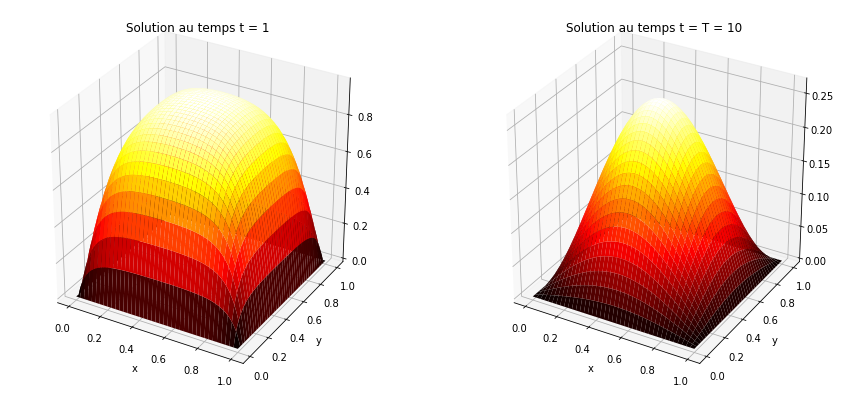

In [6]:
N = 200
t = 10

#Création du Tableau de temps
T = chaleur_triv(N,0.01,t)

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

#Création de l'environnement de la figure
fig = plt.figure(figsize = [15,7])

#Premier subplot pour la solution au temps t = 1
ax = fig.add_subplot(1,2,1, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,T[1,:].reshape(N+1,N+1) ,cmap='hot')
plt.title("Solution au temps t = 1")
plt.xlabel("x")
plt.ylabel("y")

#Second subplot pour la solution au temps t = 10
ax = fig.add_subplot(1,2,2, projection = '3d')
ax.plot_surface(X,Y,T[t,:].reshape(N+1,N+1) ,cmap='hot')
plt.title("Solution au temps t = T = 10")
plt.xlabel("x")
plt.ylabel("y")

plt.show()

Nous allons maintenant écrire un algorithme permettant de stocker la solution à chaque temps dans un fichier. 

In [7]:
def chaleur_triv_files(N,dt,t):

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    taille1 = (N+1)*(N+1)

    #Initialisation du tableau de la solution
    
    T = np.zeros(taille1)     
    
    #Initialisation de la solution finale. 
    #On met des 0 sur les bords pour valider les conditions initiales 
    #et on initialise le reste à 1. 
    
    T[N+2:taille1 - N-2] = 1.
    T[np.arange(2*N+1, taille1, N+1)] = 0
    T[np.arange(2*N+2, taille1, N+1)] = 0

    #On fait la boucle temporelle en stockant la solution 
    #à chaque temps dans un fichier txt. 
    #On utilise un solveur avec une méthode directe pour matrice sparse.
    
    for i in range (t+1):
        np.savetxt('Temps {}.txt'.format(i), T.reshape(N+1,N+1))
        T = sci.spsolve(matrix_lap2(N,dt),T)

In [11]:
chaleur_triv_files(200,0.01,10)

Dans notre répertoire, 11 fichiers textes sont apparus, chacun contenant la solution du temps $t$.

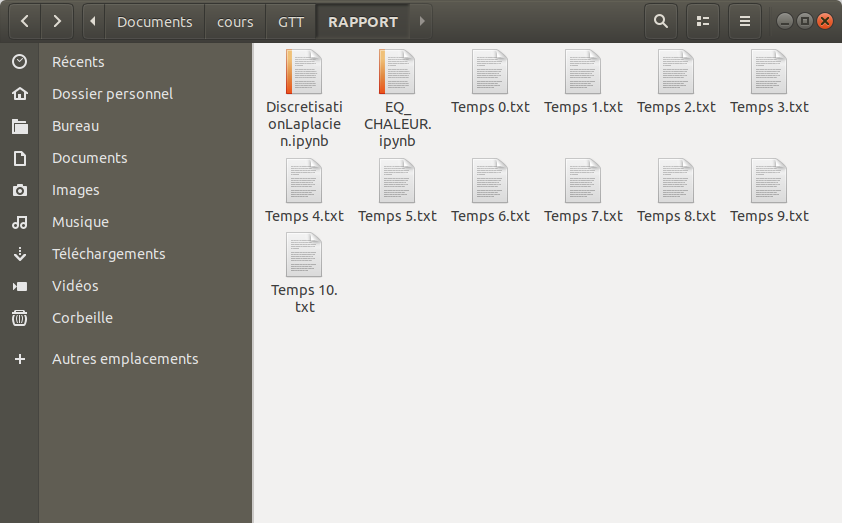

In [9]:
Image("/home/matthieu/Documents/cours/GTT/RAPPORT/Solutionstemps.png", width = 700)

Nous allons afficher la solution au temps $T = 1$ et $T = 10$ afin de voir si l'on retrouve les mêmes solutions que pour le tableau de temps précédent.

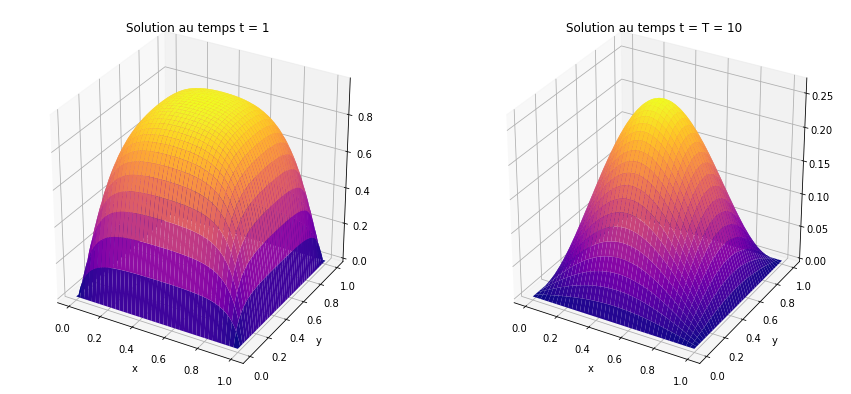

In [12]:
solt1 = np.loadtxt("Temps 1.txt")                #On charge le fichier pour le temps 1
solt10 = np.loadtxt("Temps 10.txt")              #On charge le fichier pour le temps 10

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

fig = plt.figure(figsize = [15,7])

#Premier subplot pour la solution au temps t = 1

ax = fig.add_subplot(1,2,1, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,solt1,cmap='plasma')         #On change la couleur de l'affichage 
                                                 #pour le plaisir des yeux
plt.title("Solution au temps t = 1")
plt.xlabel("x")
plt.ylabel("y")

#Second subplot pour la solution au temps t = 10

ax = fig.add_subplot(1,2,2, projection = '3d')
ax.plot_surface(X,Y,solt10 ,cmap='plasma')
plt.title("Solution au temps t = T = 10")
plt.xlabel("x")
plt.ylabel("y")

plt.show()

On remarque finalement que les courbes obtenues sont identiques à celles obtenues précédemment. Nous avons donc vu deux méthodes pour stocker les données d'une solution. Il faudra, pour des raisons de coûts de calcul ainsi qu'une éventuelle volonté de les sauvegarder sur le disque dur, privilégier le stockage des tableaux dans des fichiers textes. Cependant, dans la suite du rapport, nous utiliserons la méthode de stockage directement dans un tableaux numpy.

## Résolution de l'équation de la chaleur pour une solution $u$ donnée

Dans cette partie, on s'intéresse à la résolution de l'équation de la chaleur avec une fonction $u$ donnée, c'est à dire à la discrétisation du problème suivant: 

$$
\left\{
    \begin{array}{ll}
        \dfrac{\partial u}{\partial t} = \Delta u &{sur }\quad \Omega = [0,1]\times[0,1]\\
        u = 0 &\mbox{sur } \quad \partial \Omega 
    \end{array}
\right.
$$

où $$ u(x_1,x_2) = x_1x_2(x_1-1)^3(x_2-1)^3$$

On remarque que la fonction donnée répond bien au problème posé, particulièrement au niveau des conditions de bord. En effet, pour $x_1 = 0$, $x_2 = 0$, $x_1 = 1$, $x_2 = 1$ la fonction est nulle. Nous allons utiliser une méthode de discrétisation implicite comme précédemment. Nous allons donc réutiliser les mêmes fonctions. Le seul changement résidera dans le code de la fonction $u$. On commence par écrire la fonction dont nous avons besoin.

In [13]:
def u(x1,x2):
    return x1*x2*((x1-1.)**3)*((x2-1))**3

Et on écrit le code qui sera très inspiré de ce qui a été fait avant : 

In [14]:
def chaleur_ex(N,dt,t):
    
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)
    
    taille1 = (N+1)*(N+1)

    V = np.zeros((t+1,taille1))     #Allocation mémoire sol exacte et tableau de temps
    
    for i in np.arange(N+1):        #Calcul de la solution en tout point du maillage
        for j in np.arange(N+1):
            k = i + j*(N+1)
            V[0,k] = u(x[i],y[j])

    for i in range (t):             #Boucle temporelle utilisant le même solveur qu'avant
        V[i+1,:] = sci.spsolve(matrix_lap2(N,dt),V[i,:])

    return V

On affiche finalement le résultat pour des valeurs $N = 200$, $\delta t = 0.01$. 

Selon les informations données en cours, nous devrions obtenir les résultats suivants : 

$$\begin{array}{ll}
t &= 1 &\Longrightarrow \max(u) = 0.007773\\  
t &= 2 &\Longrightarrow \max(u) = 0.005619 
\end{array}
$$
Regardons si nous retrouvons ces résultats.

Pour t = 1, le maximum atteint est 0.007773079850730673
Pour t = 2, le maximum atteint est 0.0056197497221826655


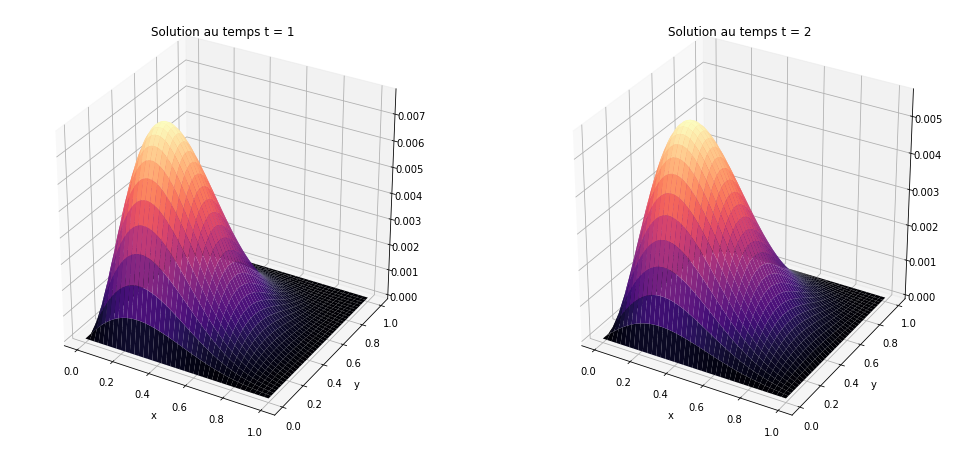

In [15]:
N = 200

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

#Création de la solution avec un temps à 2 

V = chaleur_ex(N,0.01,2)

#Affichage des maximums

print('Pour t = 1, le maximum atteint est '+str(np.max(V[1,:])))

print('Pour t = 2, le maximum atteint est '+str(np.max(V[2,:])))

#Création de l'environnement pour la figure

fig = plt.figure(figsize = [17,8])

#Premier subplot pour la solution au temps = 1
ax = fig.add_subplot(1,2,1, projection = '3d')
X,Y = np.meshgrid(x,y)
#Les maths, c'est amusant, donc on rechange les couleurs
ax.plot_surface(X,Y,V[1,:].reshape(N+1,N+1) ,cmap='magma')   
plt.title("Solution au temps t = 1")
plt.xlabel("x")
plt.ylabel("y")

#Second subplot pour la solution au temps = 2
ax = fig.add_subplot(1,2,2, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,V[2,:].reshape(N+1,N+1) ,cmap='magma')
plt.title("Solution au temps t = 2")
plt.xlabel("x")
plt.ylabel("y")

plt.show()

Comme nous obtenons les mêmes résultats que demandés en cours, nous pouvons conclure la justesse de notre approximation. Pour finir cette partie, on se propose d'afficher la solution sur une "grille de chaleur" qui pourrait ressembler, par exemple, à l'évolution de la température sur une plaque de cuisson. Pour cela on réécrit le même code et on change seulement le plot. Nous présentons la solution en utilisant les mêmes paramètres que précédemment sauf pour le temps que nous afficherons pour $t=1$ et $t=5$ afin de bien visualiser l'évolution de la solution.

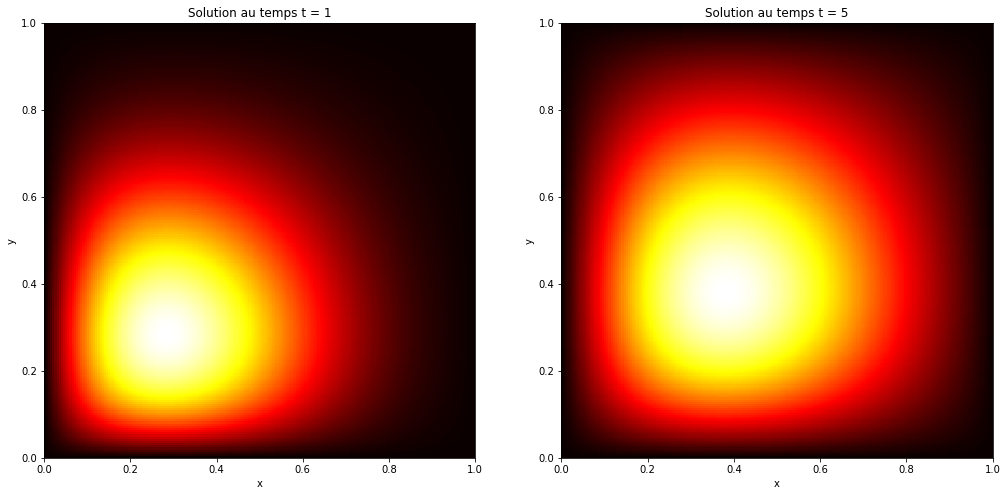

In [16]:
N = 200

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

#Création de la solution avec un temps à 2 

V = chaleur_ex(N,0.01,5)

#Création de l'environnement pour la figure

fig = plt.figure(figsize = [17,8])

#Premier subplot pour la solution au temps = 1
ax = fig.add_subplot(1,2,1)
X,Y = np.meshgrid(x,y)
ax.pcolormesh(X,Y,V[1,:].reshape(N+1,N+1) ,cmap='hot')   
plt.title("Solution au temps t = 1")
plt.xlabel("x")
plt.ylabel("y")

#Second subplot pour la solution au temps = 2
ax = fig.add_subplot(1,2,2)
X,Y = np.meshgrid(x,y)
ax.pcolormesh(X,Y,V[5,:].reshape(N+1,N+1) ,cmap='hot')
plt.title("Solution au temps t = 5")
plt.xlabel("x")
plt.ylabel("y")

plt.show()

## La fonction distance sur un domaine carré

Dans cette section, nous allons afficher la fonction distance sur un domaine carré. C'est à dire que nous allons déterminer une fonction qui va retourner la distance de chaque point du maillage par rapport à un bord. Dans notre cas, le bord sera celui du domaine $\Omega = [0,1]\times[0,1]$.

Elle est définie de la manière suivante : 

$$ \Phi(x) = \min_{y \in \partial \Omega} d(x,y)$$

Graphiquement, on obtient comme représentation, pour un domaine $\Omega$ quelconque régulier, le dessin ci-contre : 

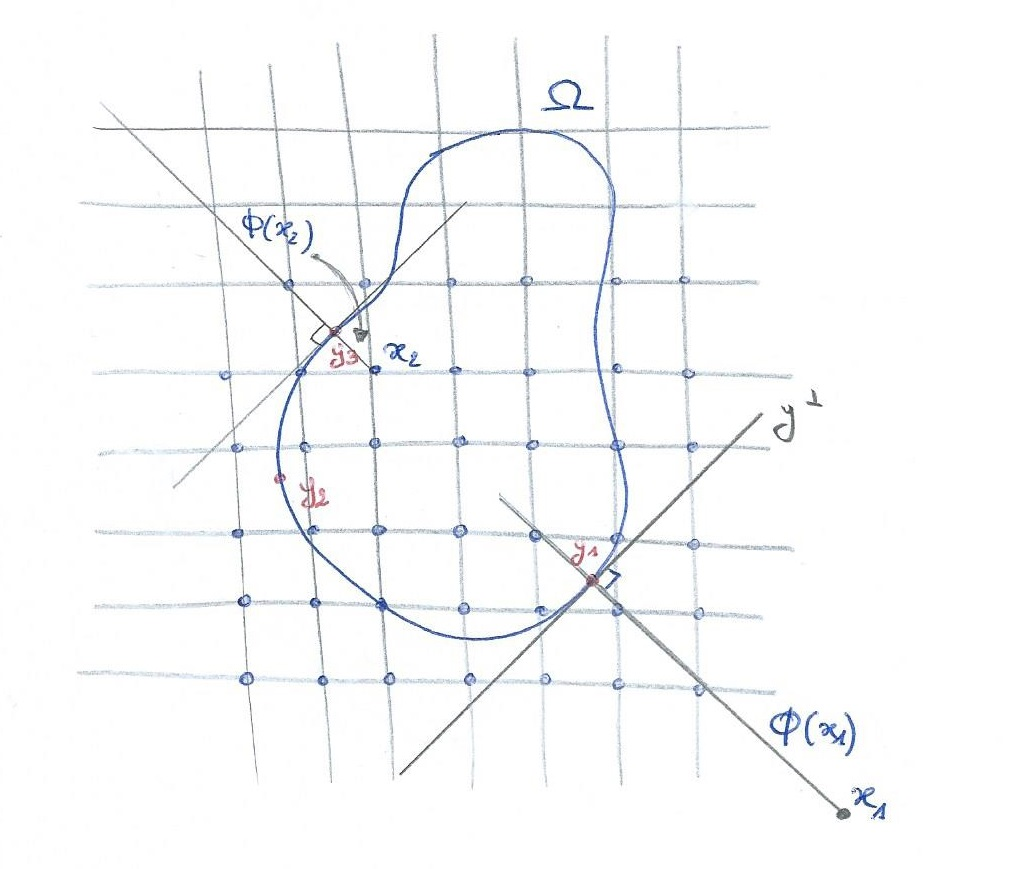

In [15]:
Image("/home/matthieu/Documents/cours/GTT/RAPPORT/Pic1.jpg", width = 600)

Il est alors évident que si $x \in \partial \Omega$ alors $\Phi(x) = 0$. A l'inverse, pour retrouver la frontière d'un domaine, il suffira de retourner le zéro de la fonction distance. On propose dans la suite une méthode de calcul de la fonction distance. Pour cela on modélise le problème de la manière suivante :

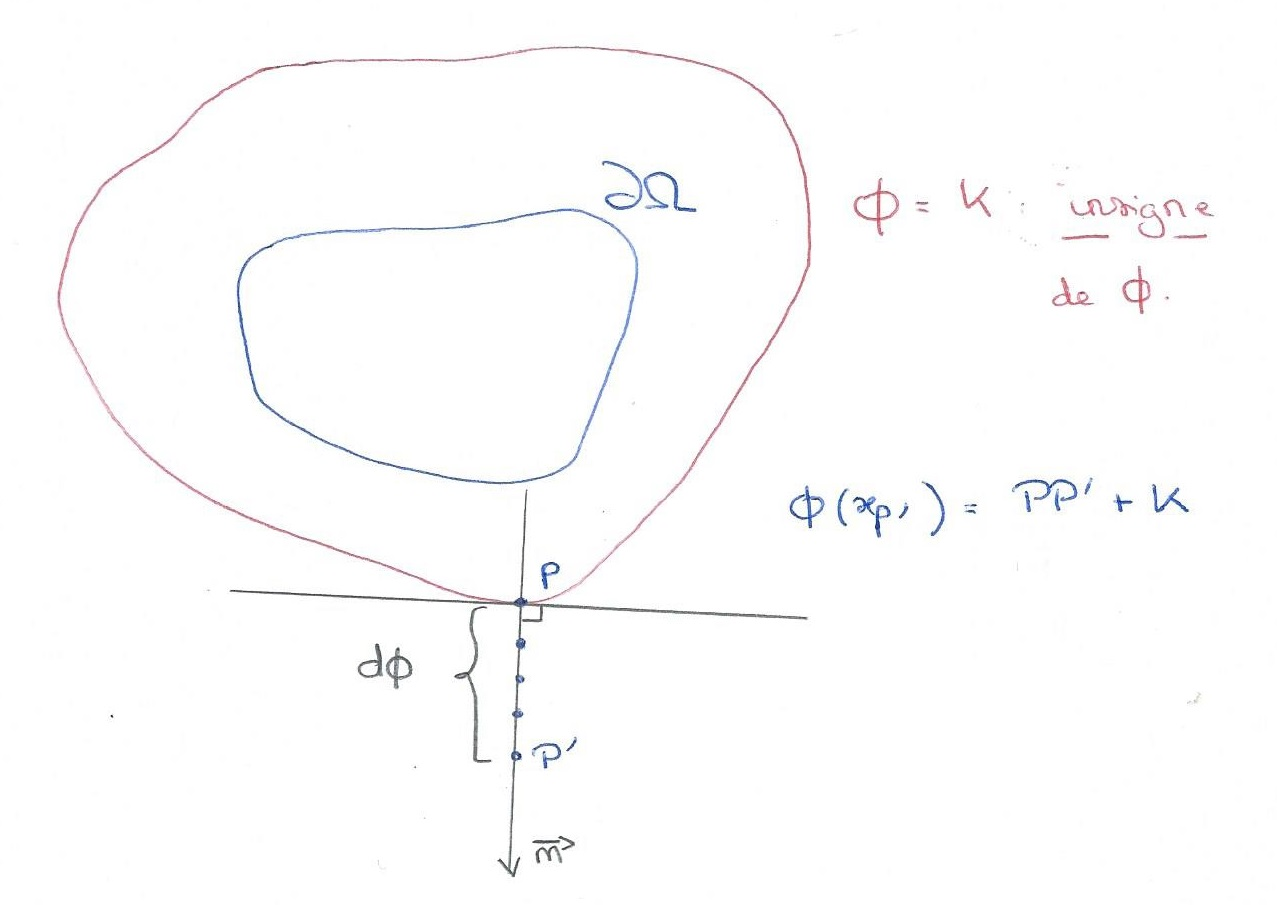

In [16]:
Image("/home/matthieu/Documents/cours/GTT/RAPPORT/Pic2.jpg", width = 600)

$d\Phi$ représente la variation de $\Phi$ lorsque l'on passe du point $P$ au point $P'$. Ainsi, on peut réécrire : 

$$ d\Phi = \nabla \Phi . \overrightarrow{PP'} $$

Or comme $\overrightarrow{PP'} = n.d\Phi$, où $n$ est le vecteur normal unitaire à $\Phi$ au point $P$ on obtient : 

$$ d\Phi = \nabla \Phi.n.d\Phi $$ 

On en déduit alors que $\nabla \Phi .n = 1$. Or comme $\Phi = K$, le vecteur gradient lui même est un vecteur normal à $\Phi$. On a donc une expression du vecteur normal unitaire comme suit : 

$$ n = \dfrac{\nabla \Phi}{||\Phi||}$$

De plus, on sait que $u.u = ||u||^2$ et donc : 

$$ \nabla \Phi . n = 1 \Longrightarrow \nabla \Phi . \dfrac{\nabla \Phi}{||\nabla \Phi||} = \dfrac{||\nabla \Phi||^2}{||\nabla \Phi||} = ||\nabla \Phi||= 1$$

On obtient une équation aux dérivées partielles telles que : 

$$\left\{
    \begin{array}{ll}
        ||\nabla \Phi || &= 1 & \mbox{sur } \Omega \\
        \Phi &= 0 & \mbox{sur } \partial \Omega
     \end{array}
  \right.
$$

Nous allons donc trouver un moyen de donner une solution approchée de ce problème en utilisant l'équation de la chaleur.

On considère tout d'abord la fonction suivante, pour tout $\epsilon \geq 0$ : 

$$T = \exp{\frac{-\Phi}{\epsilon}}$$

On calcule le Laplacien de $T$ et on trouve : 

$$\Delta T = \dfrac{-T}{\epsilon}\Delta \Phi + \dfrac{1}{\epsilon^2}||\nabla \Phi||^2 T$$

Si $||\nabla \Phi|| = 1$ alors 

$$\Delta T = \dfrac{-T}{\epsilon}\Delta \Phi + \dfrac{1}{\epsilon^2} T$$

Dans la limite pour $\epsilon \longrightarrow 0$, le terme $\dfrac{1}{\epsilon}$ est négligeable devant $\dfrac{1}{\epsilon^2}$ et on obtient finalement le problème suivant : 

$$\left\{
    \begin{array}{ll}
        ||\Delta T || &=  \dfrac{1}{\epsilon^2} T & \mbox{sur } \Omega \\
        T &= 0 & \mbox{sur } \partial \Omega
     \end{array}
  \right.
$$

Si on regarde le problème de conduction de la chaleur non stationnaire suivant : 

$$\left\{
    \begin{array}{l}
        \dfrac{\partial T}{\partial t} &= \Delta T \\
        T(x,0) &= 0 &
     \end{array}
  \right.
$$

On effectue une semi-discrétisation implicite et on obtient : 

$$ \dfrac{T^{n+1} - T^{n}}{\delta t} = \Delta T^{n+1}$$

Et on applique finalement au temps t = 0 : 

$$\dfrac{T^1 - 0 }{\delta t} = \Delta T^1 \Longrightarrow \dfrac{T^1}{\delta t} = \Delta T^1 $$

Finalement, nous venons de montrer que l'approximation de ce problème nous permet de déterminer une solution approchée de la fonction $T$. Une fois l'approximation faite, il nous suffira d'écrire : 

$$ \Phi = -\log{(T)} \times \sqrt{\delta t}$$

Ainsi nous aurons une approximation de la fonction distance $\Phi$ que nous pourrons afficher à l'écran. 

Dans notre cas (la frontière est le bord de notre domaine carré $\Omega = [0,1]\times[0,1]$ que l'on décide de modéliser en mettant la valeur $1$ sur les bords et $0$ à l'intérieur) on s'attend à observer une pyramide en 3 dimensions dont le maximum de la fonction pour $N = 1000$ et $\delta t = 10^{-5}$ serait de $0.4935556$ selon les informations du cours.

On commence par écrire le code pour stocker le résultat de l'équation de la chaleur associé au vecteur prenant $1$ sur les bords du domaine et $0$ à l'intérieur : 

In [17]:
def chaleurdist(N,dt,t):
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    taille1 = (N+1)*(N+1)
    T = np.ones((t+1,taille1))          #Initialisation de la solution finale,
                                        #1 sur les bords et 0 à l'intérieur
    T[0,N+2:taille1 - N-2] = 0
    T[0,np.arange(2*N+1, taille1, N+1)] = 1.
    T[0,np.arange(2*N+2, taille1, N+1)] = 1.

    #Boucle temporelle
    
    for i in range (t):
        T[i+1,:] = sci.spsolve(matrix_lap2(N,dt),T[i,:])

    return T

Puis on écrit une fonction qui va retourner la fonction distance : 

In [18]:
def dist(N,dt):

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    #Une itération temporelle de l'équation de la chaleur
    T = chaleurdist(N,dt,1)

    #Calcul de la fonction distance
    dist  = - np.log(T[1,:])*np.sqrt(dt)
    
    return dist

On affiche finalement la solution :

La valeur maximale de la fonction distance est 0.4935559135325694


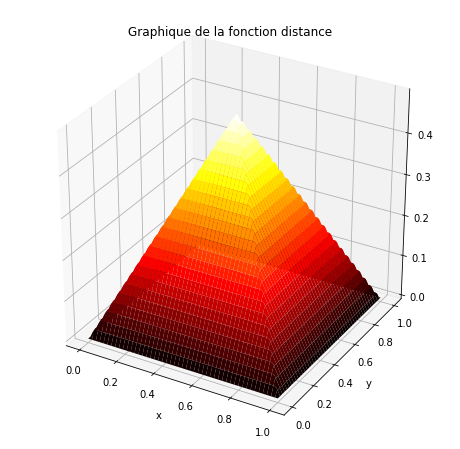

In [19]:
N = 1000

DIST = dist(N,0.00001)

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

print('La valeur maximale de la fonction distance est '+str(np.max(DIST)))

fig = plt.figure(figsize = [8,8])
    
ax = fig.add_subplot(111, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,DIST.reshape(N+1,N+1) ,cmap='hot')
plt.title("Graphique de la fonction distance")
plt.xlabel("x")
plt.ylabel("y")

plt.show()